In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
CENTERNET_TASK = "ctdet"
CENTERNET_MODEL_PATH = "/home/adrian/projects/CenterNet/models/ctdet_coco_dla_2x.pth"

data_dir='/home/adrian/data'
data_split='val2017'
annFile=f'{data_dir}/coco/annotations/instances_{data_split}.json'

classes = ("person", "dog", "motorcycle", "bear")

In [3]:
import torch.utils.data as data
from PIL import Image
import os
from datasets import ImageDataset, COCODataset

In [4]:
from torchvision import transforms
import torch.nn.functional as F
import torch

def pad_to_size(img: torch.Tensor, size):
    padded = torch.zeros(img.shape[0], size[1], size[0])
    padded[:, :img.shape[1], :img.shape[2]] = img
    return padded

mean, std = 0.1307, 0.3081
train_dataset = ImageDataset("/home/adrian/data/classy_coconut/train",
                             classes,
                               tfm=transforms.Compose([
                                 transforms.Normalize((mean,), (std,)),
                                 lambda x: pad_to_size(x, (512, 512))
                             ]))
dev_dataset = ImageDataset('/home/adrian/data/classy_coconut/dev',
                            classes,
                            tfm=transforms.Compose([
                                transforms.Normalize((mean,), (std,)),
                                lambda x: pad_to_size(x, (512, 512))
                            ]))
n_classes = len(classes)

In [5]:
print(len(train_dataset))
print(len(dev_dataset))

2953
98


In [6]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf', '#800080', '#808000', '#F08080']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(n_classes):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

In [7]:
batch_size = 2
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [8]:
# Set up data loaders
from datasets import SiameseImage

siamese_train_dataset = SiameseImage(train_dataset, True) # Returns pairs of images and target same/different
siamese_dev_dataset = SiameseImage(dev_dataset, False)
batch_size = 2
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_dev_loader = torch.utils.data.DataLoader(siamese_dev_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss

margin = 1.
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [9]:
fit(siamese_train_loader, siamese_dev_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

/home/adrian/miniconda3/envs/julia/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train: [0/2953 (0%)]	Loss: 0.249625


Train: [200/2953 (7%)]	Loss: 0.210485


Train: [400/2953 (14%)]	Loss: 0.210235


Train: [600/2953 (20%)]	Loss: 0.185972


Train: [800/2953 (27%)]	Loss: 0.186932


Train: [1000/2953 (34%)]	Loss: 0.182777


Train: [1200/2953 (41%)]	Loss: 0.169482


Train: [1400/2953 (47%)]	Loss: 0.175365


Train: [1600/2953 (54%)]	Loss: 0.152337


Train: [1800/2953 (61%)]	Loss: 0.183646


Train: [2000/2953 (68%)]	Loss: 0.185011


Train: [2200/2953 (74%)]	Loss: 0.166097


Train: [2400/2953 (81%)]	Loss: 0.153181


Train: [2600/2953 (88%)]	Loss: 0.154022


Train: [2800/2953 (95%)]	Loss: 0.166964


Epoch: 1/20. Train set: Average loss: 0.1760
Epoch: 1/20. Validation set: Average loss: 0.1777


Train: [0/2953 (0%)]	Loss: 0.016215


Train: [200/2953 (7%)]	Loss: 0.203033


Train: [400/2953 (14%)]	Loss: 0.181854


Train: [600/2953 (20%)]	Loss: 0.169093


Train: [800/2953 (27%)]	Loss: 0.166369


Train: [1000/2953 (34%)]	Loss: 0.204442


Train: [1200/2953 (41%)]	Loss: 0.180728


Train: [1400/2953 (47%)]	Loss: 0.167288


Train: [1600/2953 (54%)]	Loss: 0.150485


Train: [1800/2953 (61%)]	Loss: 0.181450


Train: [2000/2953 (68%)]	Loss: 0.143355


Train: [2200/2953 (74%)]	Loss: 0.150021


Train: [2400/2953 (81%)]	Loss: 0.162450


Train: [2600/2953 (88%)]	Loss: 0.171567


Train: [2800/2953 (95%)]	Loss: 0.166088


Epoch: 2/20. Train set: Average loss: 0.1697
Epoch: 2/20. Validation set: Average loss: 0.1455


Train: [0/2953 (0%)]	Loss: 0.328908


Train: [200/2953 (7%)]	Loss: 0.162877


Train: [400/2953 (14%)]	Loss: 0.171499


Train: [600/2953 (20%)]	Loss: 0.157974


Train: [800/2953 (27%)]	Loss: 0.148291


Train: [1000/2953 (34%)]	Loss: 0.171687


Train: [1200/2953 (41%)]	Loss: 0.153452


Train: [1400/2953 (47%)]	Loss: 0.167095


Train: [1600/2953 (54%)]	Loss: 0.171623


Train: [1800/2953 (61%)]	Loss: 0.141991


Train: [2000/2953 (68%)]	Loss: 0.134779


Train: [2200/2953 (74%)]	Loss: 0.141424


Train: [2400/2953 (81%)]	Loss: 0.147596


Train: [2600/2953 (88%)]	Loss: 0.157596


Train: [2800/2953 (95%)]	Loss: 0.142717


Epoch: 3/20. Train set: Average loss: 0.1540
Epoch: 3/20. Validation set: Average loss: 0.1399


Train: [0/2953 (0%)]	Loss: 0.028604


Train: [200/2953 (7%)]	Loss: 0.147115


Train: [400/2953 (14%)]	Loss: 0.146700


Train: [600/2953 (20%)]	Loss: 0.135956


Train: [800/2953 (27%)]	Loss: 0.119525


Train: [1000/2953 (34%)]	Loss: 0.159771


Train: [1200/2953 (41%)]	Loss: 0.144698


Train: [1400/2953 (47%)]	Loss: 0.134809


Train: [1600/2953 (54%)]	Loss: 0.157254


Train: [1800/2953 (61%)]	Loss: 0.128005


Train: [2000/2953 (68%)]	Loss: 0.131580


Train: [2200/2953 (74%)]	Loss: 0.132864


Train: [2400/2953 (81%)]	Loss: 0.133454


Train: [2600/2953 (88%)]	Loss: 0.116308


Train: [2800/2953 (95%)]	Loss: 0.110584


Epoch: 4/20. Train set: Average loss: 0.1342
Epoch: 4/20. Validation set: Average loss: 0.1481


Train: [0/2953 (0%)]	Loss: 0.138174


Train: [200/2953 (7%)]	Loss: 0.141256


Train: [400/2953 (14%)]	Loss: 0.126500


Train: [600/2953 (20%)]	Loss: 0.128917


Train: [800/2953 (27%)]	Loss: 0.117185


Train: [1000/2953 (34%)]	Loss: 0.131114


Train: [1200/2953 (41%)]	Loss: 0.124076


Train: [1400/2953 (47%)]	Loss: 0.123007


Train: [1600/2953 (54%)]	Loss: 0.126658


Train: [1800/2953 (61%)]	Loss: 0.126161


Train: [2000/2953 (68%)]	Loss: 0.114950


Train: [2200/2953 (74%)]	Loss: 0.131159


Train: [2400/2953 (81%)]	Loss: 0.128327


Train: [2600/2953 (88%)]	Loss: 0.157025


Train: [2800/2953 (95%)]	Loss: 0.180737


Epoch: 5/20. Train set: Average loss: 0.1327
Epoch: 5/20. Validation set: Average loss: 0.1415


Train: [0/2953 (0%)]	Loss: 0.106734


Train: [200/2953 (7%)]	Loss: 0.128148


Train: [400/2953 (14%)]	Loss: 0.139468


Train: [600/2953 (20%)]	Loss: 0.145007


Train: [800/2953 (27%)]	Loss: 0.145989


Train: [1000/2953 (34%)]	Loss: 0.137510


Train: [1200/2953 (41%)]	Loss: 0.135548


Train: [1400/2953 (47%)]	Loss: 0.127205


Train: [1600/2953 (54%)]	Loss: 0.109305


Train: [1800/2953 (61%)]	Loss: 0.127541


Train: [2000/2953 (68%)]	Loss: 0.118160


Train: [2200/2953 (74%)]	Loss: 0.103507


Train: [2400/2953 (81%)]	Loss: 0.119799


Train: [2600/2953 (88%)]	Loss: 0.130861


Train: [2800/2953 (95%)]	Loss: 0.127981


Epoch: 6/20. Train set: Average loss: 0.1276
Epoch: 6/20. Validation set: Average loss: 0.1727


Train: [0/2953 (0%)]	Loss: 0.277723


Train: [200/2953 (7%)]	Loss: 0.141776


Train: [400/2953 (14%)]	Loss: 0.131618


Train: [600/2953 (20%)]	Loss: 0.144439


Train: [800/2953 (27%)]	Loss: 0.119658


Train: [1000/2953 (34%)]	Loss: 0.131761


Train: [1200/2953 (41%)]	Loss: 0.129416


Train: [1400/2953 (47%)]	Loss: 0.114231


Train: [1600/2953 (54%)]	Loss: 0.125556


Train: [1800/2953 (61%)]	Loss: 0.116419


Train: [2000/2953 (68%)]	Loss: 0.095425


Train: [2200/2953 (74%)]	Loss: 0.092538


Train: [2400/2953 (81%)]	Loss: 0.129980


Train: [2600/2953 (88%)]	Loss: 0.114132


Train: [2800/2953 (95%)]	Loss: 0.119833


Epoch: 7/20. Train set: Average loss: 0.1209
Epoch: 7/20. Validation set: Average loss: 0.1499


Train: [0/2953 (0%)]	Loss: 0.170570


Train: [200/2953 (7%)]	Loss: 0.127654


Train: [400/2953 (14%)]	Loss: 0.103123


Train: [600/2953 (20%)]	Loss: 0.106988


Train: [800/2953 (27%)]	Loss: 0.090758


Train: [1000/2953 (34%)]	Loss: 0.121474


Train: [1200/2953 (41%)]	Loss: 0.096013


Train: [1400/2953 (47%)]	Loss: 0.103768


Train: [1600/2953 (54%)]	Loss: 0.104413


Train: [1800/2953 (61%)]	Loss: 0.089537


Train: [2000/2953 (68%)]	Loss: 0.108339


Train: [2200/2953 (74%)]	Loss: 0.095049


Train: [2400/2953 (81%)]	Loss: 0.094763


Train: [2600/2953 (88%)]	Loss: 0.075260


Train: [2800/2953 (95%)]	Loss: 0.099680


Epoch: 8/20. Train set: Average loss: 0.1012
Epoch: 8/20. Validation set: Average loss: 0.1589


Train: [0/2953 (0%)]	Loss: 0.315859


Train: [200/2953 (7%)]	Loss: 0.117003


Train: [400/2953 (14%)]	Loss: 0.117069


Train: [600/2953 (20%)]	Loss: 0.098982


Train: [800/2953 (27%)]	Loss: 0.088586


Train: [1000/2953 (34%)]	Loss: 0.098823


Train: [1200/2953 (41%)]	Loss: 0.101571


Train: [1400/2953 (47%)]	Loss: 0.091591


Train: [1600/2953 (54%)]	Loss: 0.111232


Train: [1800/2953 (61%)]	Loss: 0.102119


Train: [2000/2953 (68%)]	Loss: 0.089386


Train: [2200/2953 (74%)]	Loss: 0.094043


Train: [2400/2953 (81%)]	Loss: 0.095737


Train: [2600/2953 (88%)]	Loss: 0.078462


Train: [2800/2953 (95%)]	Loss: 0.086246


Epoch: 9/20. Train set: Average loss: 0.0976
Epoch: 9/20. Validation set: Average loss: 0.1538


Train: [0/2953 (0%)]	Loss: 0.300455


Train: [200/2953 (7%)]	Loss: 0.099736


Train: [400/2953 (14%)]	Loss: 0.106488


Train: [600/2953 (20%)]	Loss: 0.106542


Train: [800/2953 (27%)]	Loss: 0.085676


Train: [1000/2953 (34%)]	Loss: 0.097654


Train: [1200/2953 (41%)]	Loss: 0.097928


Train: [1400/2953 (47%)]	Loss: 0.085255


Train: [1600/2953 (54%)]	Loss: 0.113597


Train: [1800/2953 (61%)]	Loss: 0.081835


Train: [2000/2953 (68%)]	Loss: 0.089870


Train: [2200/2953 (74%)]	Loss: 0.080029


Train: [2400/2953 (81%)]	Loss: 0.085738


Train: [2600/2953 (88%)]	Loss: 0.090134


Train: [2800/2953 (95%)]	Loss: 0.092651


Epoch: 10/20. Train set: Average loss: 0.0935
Epoch: 10/20. Validation set: Average loss: 0.1460


Train: [0/2953 (0%)]	Loss: 0.143047


Train: [200/2953 (7%)]	Loss: 0.092490


Train: [400/2953 (14%)]	Loss: 0.089470


Train: [600/2953 (20%)]	Loss: 0.087664


Train: [800/2953 (27%)]	Loss: 0.081590


Train: [1000/2953 (34%)]	Loss: 0.103387


Train: [1200/2953 (41%)]	Loss: 0.086091


Train: [1400/2953 (47%)]	Loss: 0.081726


Train: [1600/2953 (54%)]	Loss: 0.093927


Train: [1800/2953 (61%)]	Loss: 0.088705


Train: [2000/2953 (68%)]	Loss: 0.083362


Train: [2200/2953 (74%)]	Loss: 0.092623


Train: [2400/2953 (81%)]	Loss: 0.077536


Train: [2600/2953 (88%)]	Loss: 0.079143


Train: [2800/2953 (95%)]	Loss: 0.087198


Epoch: 11/20. Train set: Average loss: 0.0872
Epoch: 11/20. Validation set: Average loss: 0.1519


Train: [0/2953 (0%)]	Loss: 0.135612


Train: [200/2953 (7%)]	Loss: 0.101146


Train: [400/2953 (14%)]	Loss: 0.094630


Train: [600/2953 (20%)]	Loss: 0.093568


Train: [800/2953 (27%)]	Loss: 0.078461


Train: [1000/2953 (34%)]	Loss: 0.100317


Train: [1200/2953 (41%)]	Loss: 0.077054


Train: [1400/2953 (47%)]	Loss: 0.077643


Train: [1600/2953 (54%)]	Loss: 0.089196


Train: [1800/2953 (61%)]	Loss: 0.093347


Train: [2000/2953 (68%)]	Loss: 0.080275


Train: [2200/2953 (74%)]	Loss: 0.078040


Train: [2400/2953 (81%)]	Loss: 0.088820


Train: [2600/2953 (88%)]	Loss: 0.072464


Train: [2800/2953 (95%)]	Loss: 0.087423


Epoch: 12/20. Train set: Average loss: 0.0860
Epoch: 12/20. Validation set: Average loss: 0.1502


Train: [0/2953 (0%)]	Loss: 0.177655


Train: [200/2953 (7%)]	Loss: 0.099436


Train: [400/2953 (14%)]	Loss: 0.076424


Train: [600/2953 (20%)]	Loss: 0.090274


Train: [800/2953 (27%)]	Loss: 0.072989


Train: [1000/2953 (34%)]	Loss: 0.080495


Train: [1200/2953 (41%)]	Loss: 0.078022


Train: [1400/2953 (47%)]	Loss: 0.086482


Train: [1600/2953 (54%)]	Loss: 0.093985


Train: [1800/2953 (61%)]	Loss: 0.093886


Train: [2000/2953 (68%)]	Loss: 0.089303


Train: [2200/2953 (74%)]	Loss: 0.077543


Train: [2400/2953 (81%)]	Loss: 0.089042


Train: [2600/2953 (88%)]	Loss: 0.091610


Train: [2800/2953 (95%)]	Loss: 0.068709


Epoch: 13/20. Train set: Average loss: 0.0850
Epoch: 13/20. Validation set: Average loss: 0.1496


Train: [0/2953 (0%)]	Loss: 0.197846


Train: [200/2953 (7%)]	Loss: 0.084137


Train: [400/2953 (14%)]	Loss: 0.106943


Train: [600/2953 (20%)]	Loss: 0.072560


Train: [800/2953 (27%)]	Loss: 0.084301


Train: [1000/2953 (34%)]	Loss: 0.086423


Train: [1200/2953 (41%)]	Loss: 0.080985


Train: [1400/2953 (47%)]	Loss: 0.085226


Train: [1600/2953 (54%)]	Loss: 0.093636


Train: [1800/2953 (61%)]	Loss: 0.078429


Train: [2000/2953 (68%)]	Loss: 0.089513


Train: [2200/2953 (74%)]	Loss: 0.083171


Train: [2400/2953 (81%)]	Loss: 0.078378


Train: [2600/2953 (88%)]	Loss: 0.067930


Train: [2800/2953 (95%)]	Loss: 0.076188


Epoch: 14/20. Train set: Average loss: 0.0826
Epoch: 14/20. Validation set: Average loss: 0.1456


Train: [0/2953 (0%)]	Loss: 0.148455


Train: [200/2953 (7%)]	Loss: 0.083198


Train: [400/2953 (14%)]	Loss: 0.078889


Train: [600/2953 (20%)]	Loss: 0.086037


Train: [800/2953 (27%)]	Loss: 0.066402


Train: [1000/2953 (34%)]	Loss: 0.093598


Train: [1200/2953 (41%)]	Loss: 0.086561


Train: [1400/2953 (47%)]	Loss: 0.085173


Train: [1600/2953 (54%)]	Loss: 0.086932


Train: [1800/2953 (61%)]	Loss: 0.076669


Train: [2000/2953 (68%)]	Loss: 0.081317


Train: [2200/2953 (74%)]	Loss: 0.077422


Train: [2400/2953 (81%)]	Loss: 0.066672


Train: [2600/2953 (88%)]	Loss: 0.066278


Train: [2800/2953 (95%)]	Loss: 0.099783


Epoch: 15/20. Train set: Average loss: 0.0813
Epoch: 15/20. Validation set: Average loss: 0.1517


Train: [0/2953 (0%)]	Loss: 0.116790


Train: [200/2953 (7%)]	Loss: 0.099202


Train: [400/2953 (14%)]	Loss: 0.079695


Train: [600/2953 (20%)]	Loss: 0.098559


Train: [800/2953 (27%)]	Loss: 0.067713


Train: [1000/2953 (34%)]	Loss: 0.075714


Train: [1200/2953 (41%)]	Loss: 0.089688


Train: [1400/2953 (47%)]	Loss: 0.067835


Train: [1600/2953 (54%)]	Loss: 0.077221


Train: [1800/2953 (61%)]	Loss: 0.083278


Train: [2000/2953 (68%)]	Loss: 0.070398


Train: [2200/2953 (74%)]	Loss: 0.074553


Train: [2400/2953 (81%)]	Loss: 0.079366


Train: [2600/2953 (88%)]	Loss: 0.059563


Train: [2800/2953 (95%)]	Loss: 0.076576


Epoch: 16/20. Train set: Average loss: 0.0783
Epoch: 16/20. Validation set: Average loss: 0.1469


Train: [0/2953 (0%)]	Loss: 0.078828


Train: [200/2953 (7%)]	Loss: 0.088988


Train: [400/2953 (14%)]	Loss: 0.088174


Train: [600/2953 (20%)]	Loss: 0.070458


Train: [800/2953 (27%)]	Loss: 0.066574


Train: [1000/2953 (34%)]	Loss: 0.085697


Train: [1200/2953 (41%)]	Loss: 0.075711


Train: [1400/2953 (47%)]	Loss: 0.085552


Train: [1600/2953 (54%)]	Loss: 0.072631


Train: [1800/2953 (61%)]	Loss: 0.065189


Train: [2000/2953 (68%)]	Loss: 0.073932


Train: [2200/2953 (74%)]	Loss: 0.069697


Train: [2400/2953 (81%)]	Loss: 0.086559


Train: [2600/2953 (88%)]	Loss: 0.081791


Train: [2800/2953 (95%)]	Loss: 0.071514


Epoch: 17/20. Train set: Average loss: 0.0767
Epoch: 17/20. Validation set: Average loss: 0.1464


Train: [0/2953 (0%)]	Loss: 0.197519


Train: [200/2953 (7%)]	Loss: 0.077121


Train: [400/2953 (14%)]	Loss: 0.082847


Train: [600/2953 (20%)]	Loss: 0.072609


Train: [800/2953 (27%)]	Loss: 0.068284


Train: [1000/2953 (34%)]	Loss: 0.100543


Train: [1200/2953 (41%)]	Loss: 0.075502


Train: [1400/2953 (47%)]	Loss: 0.090939


Train: [1600/2953 (54%)]	Loss: 0.071481


Train: [1800/2953 (61%)]	Loss: 0.074712


Train: [2000/2953 (68%)]	Loss: 0.079943


Train: [2200/2953 (74%)]	Loss: 0.071013


Train: [2400/2953 (81%)]	Loss: 0.079144


Train: [2600/2953 (88%)]	Loss: 0.067595


Train: [2800/2953 (95%)]	Loss: 0.078447


Epoch: 18/20. Train set: Average loss: 0.0775
Epoch: 18/20. Validation set: Average loss: 0.1462


Train: [0/2953 (0%)]	Loss: 0.209463


Train: [200/2953 (7%)]	Loss: 0.080225


Train: [400/2953 (14%)]	Loss: 0.063509


Train: [600/2953 (20%)]	Loss: 0.086743


Train: [800/2953 (27%)]	Loss: 0.069849


Train: [1000/2953 (34%)]	Loss: 0.086636


Train: [1200/2953 (41%)]	Loss: 0.078232


Train: [1400/2953 (47%)]	Loss: 0.080459


Train: [1600/2953 (54%)]	Loss: 0.071910


Train: [1800/2953 (61%)]	Loss: 0.068456


Train: [2000/2953 (68%)]	Loss: 0.075925


Train: [2200/2953 (74%)]	Loss: 0.090096


Train: [2400/2953 (81%)]	Loss: 0.060620


Train: [2600/2953 (88%)]	Loss: 0.073714


Train: [2800/2953 (95%)]	Loss: 0.076874


Epoch: 19/20. Train set: Average loss: 0.0761
Epoch: 19/20. Validation set: Average loss: 0.1463


Train: [0/2953 (0%)]	Loss: 0.099270


Train: [200/2953 (7%)]	Loss: 0.087179


Train: [400/2953 (14%)]	Loss: 0.071083


Train: [600/2953 (20%)]	Loss: 0.079578


Train: [800/2953 (27%)]	Loss: 0.071033


Train: [1000/2953 (34%)]	Loss: 0.094680


Train: [1200/2953 (41%)]	Loss: 0.074864


Train: [1400/2953 (47%)]	Loss: 0.062847


Train: [1600/2953 (54%)]	Loss: 0.070457


Train: [1800/2953 (61%)]	Loss: 0.064181


Train: [2000/2953 (68%)]	Loss: 0.064833


Train: [2200/2953 (74%)]	Loss: 0.072706


Train: [2400/2953 (81%)]	Loss: 0.078458


Train: [2600/2953 (88%)]	Loss: 0.064611


Train: [2800/2953 (95%)]	Loss: 0.101210


Epoch: 20/20. Train set: Average loss: 0.0752
Epoch: 20/20. Validation set: Average loss: 0.1463


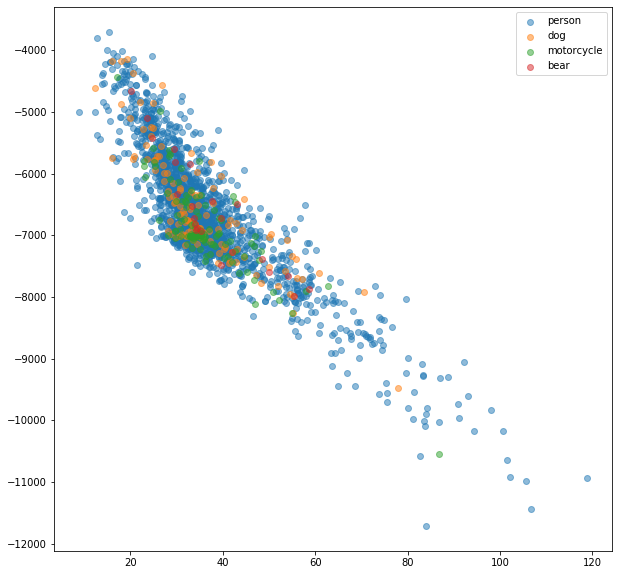

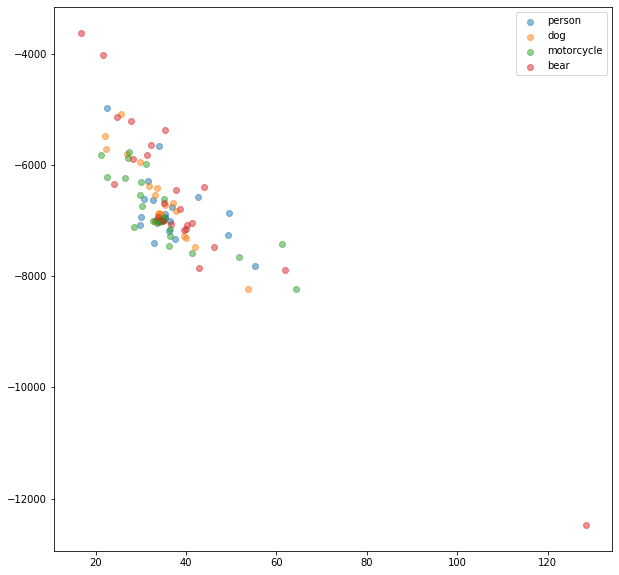

In [10]:
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_cl, train_labels_cl)
val_embeddings_cl, val_labels_cl = extract_embeddings(dev_loader, model)
plot_embeddings(val_embeddings_cl, val_labels_cl)

In [11]:
torch.save(model.state_dict(), "siamese_rgb.pth")